# Case 1
## Battery energy capacity 4000 kWh
## Battery power capacity 2000 kW

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import bess_model as bess
import run_simulation as simulation

In [5]:
# Load all datasets
speed_raw = pd.read_csv('speed_pv_sold_cured.csv')
speed_isolar_raw = pd.read_csv('isolar_1hkW.csv')
speed_bought_raw = pd.read_csv('speed_el_bought.csv')
tapetfabrik_bought_raw = pd.read_csv('tapetfabrik_el_bought.csv')
careofcarl_bought_raw = pd.read_csv('careofcarl.csv')
el_price2023_raw = pd.read_csv('el_price2023.csv')

print(speed_raw.head())
print(speed_isolar_raw.head())
print(speed_bought_raw.head())
print(tapetfabrik_bought_raw.head())
print(careofcarl_bought_raw.head())
print(el_price2023_raw.head())

             timestamp  1014
0  2023-01-01 00:00:00   0.0
1  2023-01-01 01:00:00   0.0
2  2023-01-01 02:00:00   0.0
3  2023-01-01 03:00:00   0.0
4  2023-01-01 04:00:00   0.0
             timestamp  PV(W)
0  2023-01-01 00:00:00    0.0
1  2023-01-01 01:00:00    0.0
2  2023-01-01 02:00:00    0.0
3  2023-01-01 03:00:00    0.0
4  2023-01-01 04:00:00    0.0
             timestamp    248
0  2023-01-01 00:00:00  176.0
1  2023-01-01 01:00:00  176.0
2  2023-01-01 02:00:00  170.0
3  2023-01-01 03:00:00  176.0
4  2023-01-01 04:00:00  176.0
             timestamp     35
0  2023-01-01 00:00:00  117.0
1  2023-01-01 01:00:00  114.0
2  2023-01-01 02:00:00  123.0
3  2023-01-01 03:00:00  117.0
4  2023-01-01 04:00:00  120.0
             timestamp    33
0  2023-01-01 00:00:00  13.0
1  2023-01-01 01:00:00  11.0
2  2023-01-01 02:00:00   8.0
3  2023-01-01 03:00:00  16.0
4  2023-01-01 04:00:00  13.0
   Unnamed: 0                       MTU (CET/CEST)  Day-ahead Price [EUR/MWh]  \
0           0  01.01.2023 00:00

In [11]:
speed_sold = speed_raw['1014'].rename('PV sold (kW)')
speed_sold.index = speed_raw['timestamp']

speed_bought = speed_bought_raw['248'].rename('El bought (kW)')
speed_bought.index = speed_bought_raw['timestamp']

speed_isolar = speed_isolar_raw['PV(W)'].rename('PV production (kW)')
speed_isolar.index = speed_isolar_raw['timestamp']

tapetfabrik_bought = tapetfabrik_bought_raw['35'].rename('El bought (kW)')
tapetfabrik_bought.index = tapetfabrik_bought_raw['timestamp']

careofcarl_bought = careofcarl_bought_raw['33'].rename('El bought (kW)')
careofcarl_bought.index = careofcarl_bought_raw['timestamp']

el_price = (el_price2023_raw['Day-ahead Price [EUR/MWh]'] / 1000).rename('EUR/kWh')
el_price.index = speed_raw['timestamp']

print(speed_sold.isnull().any(), 
      speed_bought.isnull().any(), 
      speed_isolar.isnull().any(), 
      tapetfabrik_bought.isnull().any(),
      careofcarl_bought.isnull().any(),
      el_price.isnull().any()
     )

False False False False False False


In [13]:
speed_demand = speed_isolar - speed_sold + speed_bought
speed_demand.isnull().any()
tapetfabrik_demand = tapetfabrik_bought
careofcarl_demand = careofcarl_bought

# Scenario 1: Base case
Building A, B and C operates individually. Building A has PV installed and excess PV are exported to the grid, but no virtual power sharing enabled with building B and C (No energy community established). No BESS installed.  

**Indicators**:
* PV self-consumption
* Electricity bought from the grid
* Total electricity cost

In [58]:
pv_self_s1 = (speed_isolar - speed_sold).sum() / speed_isolar.sum()
print('PV self consumption scenario 1:', pv_self_s1)

PV self consumption scenario 1: 0.3771063494419648


In [60]:
el_bought_s1 = speed_bought + tapetfabrik_bought + careofcarl_bought
print('Electricity bought from grid scenario 1 (kWh):', el_bought_s1.sum())

Electricity bought from grid scenario 1 (kWh): 4725528.17


In [61]:
el_cost_s1 = (el_price * el_bought_s1).sum()
el_revenue_s1 = (el_price * speed_sold).sum()
el_net_cost_s1 = el_cost_s1 - el_revenue_s1
print('Electricity cost scenario 1 (€):', el_cost_s1)
print('Electricity revenue scenario 1 (€):', el_revenue_s1)
print('Net electricity cost scenario 1 (€):', el_net_cost_s1)

Electricity cost scenario 1 (€): 285750.6194973
Electricity revenue scenario 1 (€): 69194.95373836404
Net electricity cost scenario 1 (€): 216555.66575893597


# Scenario 2: Base + PV virtual sharing
Building A, B and C establishes an energy community, so that excess PV can be virtually shared by building B and C. No BESS installed.  

**Indicators**:
* PV self-consumption
* Electricity bought from the grid
* Total electricity cost

In [62]:
diff = speed_isolar - (speed_demand + tapetfabrik_demand + careofcarl_demand)
el_bought_s2 = -diff.where(diff<0).fillna(0)
el_bought_s2.shape
el_bought_s2.sum()
print('Electricity bought from grid scenario 2 (kWh):', el_bought_s2.sum())

Electricity bought from grid scenario 2 (kWh): 4031995.093941369


In [63]:
pv_self_s2 = ((speed_demand + tapetfabrik_demand + careofcarl_demand).sum() - el_bought_s2.sum()) / speed_isolar.sum()
pv_self_s2
print('PV self consumption scenario 2:', pv_self_s2)

PV self consumption scenario 2: 0.6522416191966164


In [65]:
el_cost_s2 = (el_price * (el_bought_s2)).sum()
speed_sold_s2 = diff.where(diff>0).fillna(0)

el_revenue_s2 = (el_price * speed_sold_s2).sum()
el_net_cost_s2 = el_cost_s2 - el_revenue_s2
print('Electricity cost scenario 2 (€):', el_cost_s2)
print('Electricity revenue scenario 2 (€):', el_revenue_s2)
print('Net electricity cost scenario 2 (€):', el_net_cost_s2)

Electricity cost scenario 2 (€): 248427.1697114401
Electricity revenue scenario 2 (€): 31871.503952504172
Net electricity cost scenario 2 (€): 216555.66575893594


# Scenario 3
Building A, B and C establishes an energy community, so that excess PV can be virtually shared by building B and C. This energy community is further enhanced by a BESS installed.

**Indicators**:

* PV self-consumption
* Electricity bought from the grid
* Total electricity cost

In [47]:
total_demand = speed_demand + tapetfabrik_demand + careofcarl_demand
battery = bess.BatteryEnergyStorageSystem()
battery.get_battery_state()

{'soc': 0.5,
 'existing energy': 2000.0,
 'total charged energy': 0,
 'total discharged energy': 0,
 'total losses': 0}

In [48]:
results = simulation.run_simulation(battery, speed_isolar, total_demand, el_price)
results

,timestamp,pv_generation,building_demand,electricity_prices,energy_movement,battery_soc,battery_energy,grid_power,electricity_cost
0,2023-01-01 00:00:00,0.0,306.00,0.00201,-290.70,0.427325,1709.30,-15.30,-0.030753
1,2023-01-01 01:00:00,0.0,301.00,0.00138,-285.95,0.355837,1423.35,-15.05,-0.020769
2,2023-01-01 02:00:00,0.0,301.00,0.00009,-285.95,0.284350,1137.40,-15.05,-0.001355
3,2023-01-01 03:00:00,0.0,309.00,0.00008,-293.55,0.210962,843.85,-15.45,-0.001236
4,2023-01-01 04:00:00,0.0,309.00,0.00005,-293.55,0.137575,550.30,-15.45,-0.000772
...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,0.0,303.90,0.03964,-0.00,0.100000,400.00,-303.90,-12.046596
8756,2023-12-31 20:00:00,0.0,303.87,0.03489,-0.00,0.100000,400.00,-303.87,-10.602024
8757,2023-12-31 21:00:00,0.0,308.95,0.02960,-0.00,0.100000,400.00,-308.95,-9.144920
8758,2023-12-31 22:00:00,0.0,309.37,0.02867,-0.00,0.100000,400.00,-309.37,-8.869638


In [126]:
results.set_index(results['timestamp'], inplace=True)
results

,timestamp,pv_generation,building_demand,electricity_prices,energy_movement,battery_soc,battery_energy,grid_power,electricity_cost
timestamp,,,,,,,,,
2023-01-01 00:00:00,2023-01-01 00:00:00,0.0,306.00,0.00201,-290.70,0.427325,1709.30,-15.30,-0.030753
2023-01-01 01:00:00,2023-01-01 01:00:00,0.0,301.00,0.00138,-285.95,0.355837,1423.35,-15.05,-0.020769
2023-01-01 02:00:00,2023-01-01 02:00:00,0.0,301.00,0.00009,-285.95,0.284350,1137.40,-15.05,-0.001355
2023-01-01 03:00:00,2023-01-01 03:00:00,0.0,309.00,0.00008,-293.55,0.210962,843.85,-15.45,-0.001236
2023-01-01 04:00:00,2023-01-01 04:00:00,0.0,309.00,0.00005,-293.55,0.137575,550.30,-15.45,-0.000772
...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,2023-12-31 19:00:00,0.0,303.90,0.03964,-0.00,0.100000,400.00,-303.90,-12.046596
2023-12-31 20:00:00,2023-12-31 20:00:00,0.0,303.87,0.03489,-0.00,0.100000,400.00,-303.87,-10.602024
2023-12-31 21:00:00,2023-12-31 21:00:00,0.0,308.95,0.02960,-0.00,0.100000,400.00,-308.95,-9.144920


In [148]:
el_imported = results['grid_power'].where(results['grid_power']<0).fillna(0)
el_imported.reindex(results['timestamp'])
pv_self_s3 = (total_demand.sum() + el_imported.sum()) / speed_isolar.sum()
pv_self_s3

np.float64(0.8321451110814436)

In [51]:
el_bought_s3 = -el_imported.sum()
el_bought_s3

np.float64(3578512.6224580356)

In [56]:
el_cost_s3 = -results['electricity_cost'][results['electricity_cost']<0].sum()
print('Electricity cost scenario 3 (€):', el_cost_s3)
el_revenue_s3 = results['electricity_cost'][results['electricity_cost']>0].sum()
print('Electricity revenue scenario 3 (€):', el_revenue_s3)
el_net_cost_s3 = el_cost_s3 - el_revenue_s3
print('Net electricity cost scenario 3 (€):', el_net_cost_s3)

Electricity cost scenario 3 (€): 229341.12967796152
Electricity revenue scenario 3 (€): 12506.640215499541
Net electricity cost scenario 3 (€): 216834.489462462


# Results visualisation

Left panel: (representative days) PV output, Self-consumption, Battery charging/discharging, Battery SoC, Electricity price

Right Panel: PV self-consumption, El bought and El costs for 3 scenarios

In [150]:
start = '2023-05-15 06:00:00'
end = '2023-05-18 06:00:00'
timestamps = pd.date_range(start=start, end=end, freq='h')
pv_output = speed_isolar[start:end]
self_consumption1 = (speed_isolar - speed_sold)[start:end]
self_consumption2 = (speed_demand + tapetfabrik_demand + careofcarl_demand - el_bought_s2)[start:end]
self_consumption3 = (total_demand + el_imported)[start:end]
charge_discharge = results['energy_movement'][start:end]
battery_soc = results['battery_soc'][start:end]
load = total_demand[start:end]
selected_price = el_price[start:end]

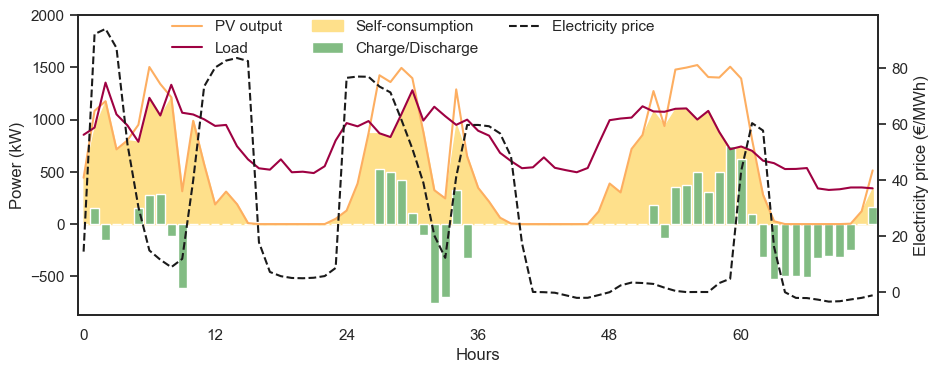

In [185]:
fig = plt.figure(figsize=(4,3))
sns.set_theme(style='white')
#plt.style.use('seaborn-white')
ax = fig.add_axes([0,0,2,1])
ax_twin = ax.twinx() # share the x, electricity price

sns.lineplot(x=pv_output.index, y=pv_output.values, ax=ax, color='#fdae61', alpha=1, label='PV output')
sns.lineplot(x=load.index, y=load.values, ax=ax, color='#9e0142', label='Load')
sns.lineplot(x=selected_price.index, y=selected_price.values*1000, ax=ax_twin, linestyle='--', color='k', label='Electricity price')
ax.stackplot(self_consumption2.index, self_consumption2.values, color='#fee08b', labels=['Self-consumption'])
sns.barplot(x=charge_discharge.index, y=charge_discharge, ax=ax, color='#78c679', label='Charge/Discharge')

ax.set_xticks([i for i in range(0,72,12)])
ax.set_xticklabels([i for i in range(0,72,12)])
ax.set_xlabel('Hours')

ax.set_ylabel('Power (kW)')
ax.set_yticks([i for i in range(-500, 2500, 500)])
ax_twin.set_ylabel('Electricity price (€/MWh)')
ax_twin.get_legend().remove()

handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_twin.get_legend_handles_labels()

ax.legend(handles1+handles2, labels1+labels2, bbox_to_anchor=(0.1, 0.82), ncol=3, frameon=0)
plt.savefig('dashboard.png', dpi=600, bbox_inches='tight')

plt.show()

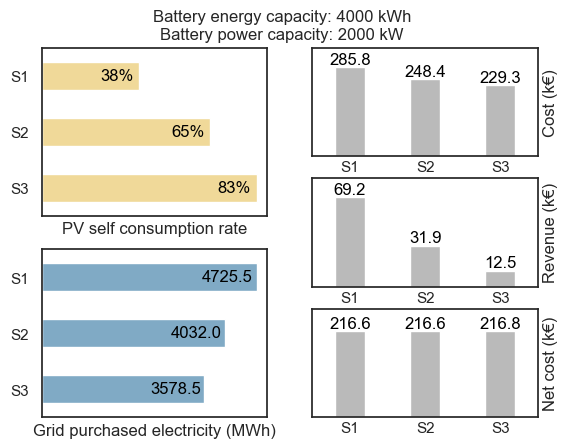

In [187]:
fig = plt.figure()
sns.set_theme(style='white')
ax0 = fig.add_subplot(2,2,1)
ax1 = fig.add_subplot(2,2,3)
s = ['S1', 'S2', 'S3']

# PV self consumption rate
sns.barplot(x=[pv_self_s1, pv_self_s2, pv_self_s3], y=s, ax=ax0, orient='h', width=0.5, color='#fee08b')
for bar in ax0.patches:
    width = bar.get_width()  # Get bar length
    ax0.text(width - 0.15,  # X position (slightly to the right of the bar)
            bar.get_y() + bar.get_height() / 2,  # Y position (center of the bar)
            f"{width:.0%}",  # Format as percentage
            ha="left", va="center", fontsize=12, color="black")
ax0.set_xticks([])
ax0.set_xlabel('PV self consumption rate')

# Grid purchased electricity 
sns.barplot(x=[el_bought_s1.sum()/1000, el_bought_s2.sum()/1000, el_bought_s3.sum()/1000], 
            y=s, ax=ax1, orient='h', width=0.5, color='#74add1')
for bar in ax1.patches:
    width = bar.get_width()  # Get bar length
    ax1.text(width - 1200,  # X position (slightly to the right of the bar)
            bar.get_y() + bar.get_height() / 2,  # Y position (center of the bar)
            f"{width:.5}",  # Format as percentage
            ha="left", va="center", fontsize=12, color="black")
ax1.set_xticks([])
ax1.set_xlabel('Grid purchased electricity (MWh)')

# Electricity cost
ax2 = fig.add_subplot(3,2,2, sharex=ax4)
sns.barplot(x=s, y=[el_cost_s1/1000, el_cost_s2/1000, el_cost_s3/1000], ax=ax2, color='#bababa', width=0.4)
ax2.tick_params(axis="x", pad=-3) 
ax2.set_yticks([i for i in range(0,350)])
ax2.set_yticklabels([])
ax2.set_ylabel('Cost (k€)')
ax2.yaxis.set_label_position('right')
# Add text labels
for bar in ax2.patches:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.02, 
            f"{height:.4}", ha="center", va="bottom", fontsize=12, color="black")


ax3 = fig.add_subplot(3,2,4, sharex=ax4)
sns.barplot(x=s, y=[el_revenue_s1/1000, el_revenue_s2/1000, el_revenue_s3/1000], ax=ax3, color='#bababa', width=0.4)
ax3.tick_params(axis="x", pad=-3)
ax3.set_yticks([i for i in range(0,85)])
ax3.set_yticklabels([])
ax3.set_ylabel('Revenue (k€)', loc='center')
ax3.yaxis.set_label_position('right')
# Add text labels
for bar in ax3.patches:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, height + 0.02, 
            f"{height:.3}", ha="center", va="bottom", fontsize=12, color="black")

ax4 = fig.add_subplot(3,2,6)
sns.barplot(x=s, y=[el_net_cost_s1/1000, el_net_cost_s2/1000, el_net_cost_s3/1000], ax=ax4, color='#bababa', width=0.4)
ax4.tick_params(axis="x", pad=-3)
ax4.set_yticks([i for i in range(0,275)])
ax4.set_yticklabels([])
ax4.set_ylabel('Net cost (k€)')
ax4.yaxis.set_label_position('right')
# Add text labels
for bar in ax4.patches:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, height + 0.02, 
            f"{height:.4}", ha="center", va="bottom", fontsize=12, color="black")

plt.suptitle('Battery energy capacity: 4000 kWh\nBattery power capacity: 2000 kW', fontsize=12, ha='center', y=0.96)

plt.savefig('results.png', dpi=600, bbox_inches='tight')

In [146]:
total_demand

timestamp
2023-01-01 00:00:00    306.00
2023-01-01 01:00:00    301.00
2023-01-01 02:00:00    301.00
2023-01-01 03:00:00    309.00
2023-01-01 04:00:00    309.00
                        ...  
2023-12-31 19:00:00    303.90
2023-12-31 20:00:00    303.87
2023-12-31 21:00:00    308.95
2023-12-31 22:00:00    309.37
2023-12-31 23:00:00    300.98
Length: 8760, dtype: float64